In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import requests

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers 
from tensorflow.keras import Model
from tensorflow.keras.applications.xception import Xception
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
pip list | grep tensorflow

tensorflow                    2.4.1         
tensorflow-datasets           4.0.1         
tensorflow-estimator          2.4.0         
tensorflow-gcs-config         2.4.0         
tensorflow-hub                0.11.0        
tensorflow-metadata           0.29.0        
tensorflow-probability        0.12.1        


In [ ]:
IMAGE_SIZE = (128, 128)
INPUT_SHAPE = IMAGE_SIZE + (3,)
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128

In [ ]:
gdrive_dir = "/content/drive/MyDrive"
working_dir = os.path.join(gdrive_dir, "CS3244 Project")
data_dir = os.path.join(working_dir, "landmarks/local")
model_root_dir = os.path.join(working_dir, "models/Xihao")

In [ ]:
num_of_labels = len(os.listdir(data_dir))

print('number of labels:', num_of_labels)

number of labels: 11


In [ ]:
# dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, interpolation="bilinear")

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255, 
    validation_split = VALIDATION_SPLIT,
    rotation_range = 30,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    brightness_range = [0.9,1.1],
    fill_mode = 'nearest'
)
train_generator = train_datagen.flow_from_directory(
    data_dir,
    subset = "training", 
    shuffle = True, 
    target_size = IMAGE_SIZE ,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split = VALIDATION_SPLIT
)
validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    subset = "validation", 
    shuffle = False, 
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

Found 3650 images belonging to 11 classes.
Found 909 images belonging to 11 classes.


In [ ]:
base_model = Xception(
    input_shape = INPUT_SHAPE,
    include_top = False,
    weights='imagenet'
)

In [ ]:
base_model.summary()

In [ ]:
load_model_name = "xception_international_base_normalised_adam_2_7"
load_model_dir = os.path.join(model_root_dir, load_model_name)

trained_model = tf.keras.models.load_model(load_model_dir)

In [ ]:
trained_model.summary()

In [ ]:
last_layer = trained_model.get_layer("block14_sepconv2_act")
last_output = last_layer.output

In [ ]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization(momentum=0.95, name="batch_norm_pre-output")(x)
x = layers.Dense(num_of_labels, activation='softmax')(x)

model = Model(trained_model.input, x)

In [ ]:
model = trained_model

In [ ]:
model.compile(
    loss = 'categorical_crossentropy',
    # optimizer = tf.keras.optimizers.RMSprop(lr=0.001),
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.001),
    metrics = ['accuracy']
)

In [ ]:
model.summary()

In [ ]:
steps_per_epoch = int(train_generator.samples / BATCH_SIZE)
validation_steps = int(validation_generator.samples / BATCH_SIZE)

print("Steps per epoch:", steps_per_epoch)
print("Validation steps:", validation_steps)

Steps per epoch: 28
Validation steps: 7


In [ ]:
 history = model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = 20,
    steps_per_epoch = steps_per_epoch,
    validation_steps = validation_steps
)


Epoch 1/20
28/28 [==============================] - ETA: 0s - loss: 0.0812 - accuracy: 0.9727

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


28/28 [==============================] - 73s 3s/step - loss: 0.0812 - accuracy: 0.9727 - val_loss: 1.2105 - val_accuracy: 0.7489
Epoch 2/20
28/28 [==============================] - 70s 3s/step - loss: 0.0862 - accuracy: 0.9722 - val_loss: 1.2086 - val_accuracy: 0.7489
Epoch 3/20
28/28 [==============================] - 70s 3s/step - loss: 0.0840 - accuracy: 0.9722 - val_loss: 1.2134 - val_accuracy: 0.7478
Epoch 4/20
28/28 [==============================] - 70s 3s/step - loss: 0.0904 - accuracy: 0.9739 - val_loss: 1.2107 - val_accuracy: 0.7489
Epoch 5/20
28/28 [==============================] - 70s 3s/step - loss: 0.0746 - accuracy: 0.9773 - val_loss: 1.2077 - val_accuracy: 0.7489
Epoch 6/20
28/28 [==============================] - 70s 3s/step - loss: 0.0891 - accuracy: 0.9705 - val_loss: 1.2110 - val_accuracy: 0.7478
Epoch 7/20
28/28 [==============================] - 71s 3s/step - loss: 0.0766 - accuracy: 0.9739 - val_loss: 1.2053 - val_accuracy: 0.7489
Epoch 8/20
28/28 [=============

In [ ]:
save_model_name = "imagenet_xception_normalised_local_3"
save_model_dir = os.path.join(model_root_dir, save_model_name)

tf.keras.models.save_model(model, save_model_dir)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/CS3244 Project/models/Xihao/imagenet_xception_normalised_local_3/assets


Text(0.5, 1.0, 'Training and validation loss')

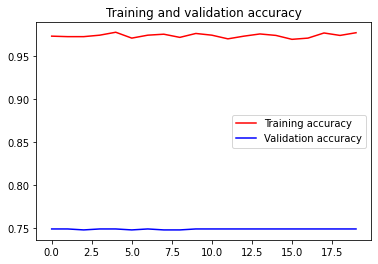

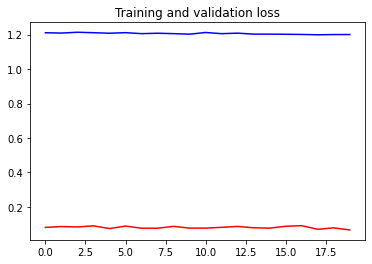

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

In [ ]:
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTcXUZCZCDJxTd5ZZgMcQ4LIeNGCP2MYYhI0A&usqp=CAU"

try:
  image_data = requests.get(url, stream=True).raw
except Exception as e:
  print('Warning: Could not download image from %s' % url)
  print('Error: %s' %e)
  raise

try:
  pil_image = Image.open(image_data)
except Exception as e:
  print('Warning: Failed to parse image')
  print('Error: %s' %e)
  raise

try:
  img = pil_image.convert('RGB').resize(IMAGE_SIZE)
except:
  print('Warning: Failed to format image')
  raise

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

classes = model.predict(x)
labels = list(train_generator.class_indices.keys())

for i in range(len(classes[0])):
  print("%15s: %s" % (labels[i], classes[0][i]))

NameError: ignored